# A Demonstration of Tensorflow on the non_MNIST Dataset

The following demonstration is adapted from a variety of sources listed below:
* Udacity's [deep learning course](www.udacity.com)
* Tensorflow [Tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/index.html)

Neural networks are difficult to understand. A fantastic website that I have been using to understand not only how they generally work, but the math behind them is right here:

* Michael Nielsen's [Deep Learning](http://neuralnetworksanddeeplearning.com/index.html) book.

CNNs are another leap of understanding after NN. In order to gain an intuitive understanding of Convolutional Neural Networks you should check out the following.

* [Intuitive understanding of CNNs](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)
* [More in-depth understanding of CNNs](http://cs231n.stanford.edu/)





In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Obtain the Data
First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [15]:
xurl = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent
                
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labelled A through J.

In [16]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
    
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


## Take a quick peak at the data

In [17]:
path = train_folders[0]
image_list = os.listdir(path)

for image in image_list[:10]:
    #formats the filename to have path/image
    display(Image(filename="{0}/{1}".format(path, image)))

## Preprocessing
Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) shape = (200000,28,28) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. Example train_dataset[0] = the first 28x28 picture, "train_dataset[0][0][0] = normalized pixel value of picture 1.

A few images might not be readable, we'll just skip them.

In [18]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                                                 dtype=np.float32)

    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
                #normalize each of the pixel values
            image_data = (ndimage.imread(image_file).astype(float) - 
                                        pixel_depth / 2) / pixel_depth

            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
         print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
                
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [21]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
        
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                                        
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
        
    return valid_dataset, valid_labels, train_dataset, train_labels
                                         
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Now lets visualize what we have done.

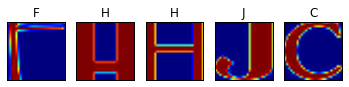

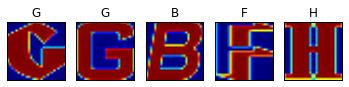

In [26]:
#display a couple of random pictures.
import random
def showProcessedRandom(dataset,labels,n): # shows size of the sample
    indices=random.sample(range(0,labels.shape[0]),n)
    fig=plt.figure()
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        plt.imshow(dataset[indices[i],:,:])
        #The ord() function returns the ASCII value of the first character of a string.
        a.set_title(chr(labels[indices[i]]+ord('A')))
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    plt.show()
    
showProcessedRandom(train_dataset,train_labels,5) 
showProcessedRandom(test_dataset,test_labels,5)

And finally, lets check that the data is balanced.

In [27]:
for i in range(10):
    
    print (train_datasets[i])
    obj = pickle.load(open(train_datasets[i], "r"))
    print (len(obj))

notMNIST_large/A.pickle
52909
notMNIST_large/B.pickle
52911
notMNIST_large/C.pickle
52912
notMNIST_large/D.pickle
52911
notMNIST_large/E.pickle
52912
notMNIST_large/F.pickle
52912
notMNIST_large/G.pickle
52912
notMNIST_large/H.pickle
52912
notMNIST_large/I.pickle
52912
notMNIST_large/J.pickle
52911


For training any sort of algorithm, we need to randomize the data.

In [28]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## CTL+S Trust me, you'll thank me for this later

In [29]:
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    #dictionaries that contain 3D arrays (train_size,28,28)
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

# Tensorflow

Make sure you have tensorflow [installed](https://www.tensorflow.org/) before starting this section, as it can be an annoying process. Don't worry about the whole GPU thing (unless you are into that stuff), this program can be run on a 2009 macbookpro using the CPU settings. 

First we will reload the data from our checkpoint and reshape it as input to a Logistic Regression

* data as a flat matrix,
* labels as float 1-hot encodings.



In [74]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    


Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [50]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


## Logistic Regression

The first construct we will make is a regular Logistic Regression using gradient descent (GD). This is to illustrate how much more quickly stochastic gradient decent works (later examples). I needed to reduce the train_subset size to 10,000 in order for this to run on my laptop.

In [51]:
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Now that we've defined the graph, we can run it in the tensorflow session, and check out the results.

In [45]:
num_steps = 801
import time
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
                    / predictions.shape[0])
start = time.clock()
with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
                predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
end = time.clock()

print ("Running time : %s seconds" % (end - start))

Initialized
Loss at step 0: 18.712330
Training accuracy: 9.6%
Validation accuracy: 12.2%
Loss at step 100: 2.288794
Training accuracy: 72.1%
Validation accuracy: 69.9%
Loss at step 200: 1.818811
Training accuracy: 74.9%
Validation accuracy: 72.6%
Loss at step 300: 1.574937
Training accuracy: 76.4%
Validation accuracy: 73.6%
Loss at step 400: 1.412480
Training accuracy: 77.1%
Validation accuracy: 74.3%
Loss at step 500: 1.292673
Training accuracy: 77.7%
Validation accuracy: 74.8%
Loss at step 600: 1.199457
Training accuracy: 78.5%
Validation accuracy: 75.1%
Loss at step 700: 1.124339
Training accuracy: 79.2%
Validation accuracy: 75.3%
Loss at step 800: 1.062138
Training accuracy: 79.7%
Validation accuracy: 75.4%
Test accuracy: 82.6%
Running time : 171.521572 seconds


Let's now switch to stochastic gradient descent training instead, which is much faster. Also, we'll set the training size back to 200,000.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

In [43]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

and running the code, while selecting a random batch size through each training period:

In [40]:
num_steps = 3001
start = time.clock()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
end = time.clock()

print ("Running time : %s seconds" % (end - start))

Initialized
Minibatch loss at step 0: 15.436899
Minibatch accuracy: 12.5%
Validation accuracy: 14.3%
Minibatch loss at step 500: 1.662611
Minibatch accuracy: 73.4%
Validation accuracy: 74.7%
Minibatch loss at step 1000: 2.141371
Minibatch accuracy: 71.1%
Validation accuracy: 75.9%
Minibatch loss at step 1500: 0.828968
Minibatch accuracy: 82.0%
Validation accuracy: 76.7%
Minibatch loss at step 2000: 1.172589
Minibatch accuracy: 78.9%
Validation accuracy: 77.0%
Minibatch loss at step 2500: 0.951914
Minibatch accuracy: 78.1%
Validation accuracy: 77.5%
Minibatch loss at step 3000: 0.727801
Minibatch accuracy: 81.2%
Validation accuracy: 77.8%
Test accuracy: 86.1%
Running time : 12.469908 seconds


## Neural Networks
The following is a single hidden layer (1024) neural network with a ReLu non-linearity


In [53]:
batch_size = 128
n_hidden_nodes = 1024


graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_01 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden_nodes]))
    weights_12 = tf.Variable(tf.truncated_normal([n_hidden_nodes, num_labels]))
    biases_01 = tf.Variable(tf.zeros([n_hidden_nodes]))
    biases_12 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    z_01= tf.matmul(tf_train_dataset, weights_01) + biases_01
    h1 = tf.nn.relu(z_01)
    z_12 = tf.matmul(h1, weights_12) + biases_12
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(z_12, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(z_12)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_01) + biases_01), weights_12) + biases_12)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_01) + biases_01), weights_12) + biases_12)

Running the NN...

In [48]:
num_steps = 3001
start = time.clock()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    for step in xrange(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print ("Minibatch loss at step", step, ":", l)
            print ("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print ("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print ("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    
end = time.clock()
print ("Running time : %s seconds" % (end - start))

Initialized
Minibatch loss at step 0 : 309.44
Minibatch accuracy: 13.3%
Validation accuracy: 31.7%
Minibatch loss at step 500 : 6.23858
Minibatch accuracy: 89.1%
Validation accuracy: 80.2%
Minibatch loss at step 1000 : 21.4135
Minibatch accuracy: 71.1%
Validation accuracy: 78.8%
Minibatch loss at step 1500 : 4.37797
Minibatch accuracy: 82.8%
Validation accuracy: 80.6%
Minibatch loss at step 2000 : 3.12574
Minibatch accuracy: 82.0%
Validation accuracy: 81.3%
Minibatch loss at step 2500 : 2.18109
Minibatch accuracy: 90.6%
Validation accuracy: 82.5%
Minibatch loss at step 3000 : 4.58513
Minibatch accuracy: 83.6%
Validation accuracy: 81.9%
Test accuracy: 88.2%
Running time : 231.935389 seconds


## Finally, convolutional neural networks

I'm only going to build a small CNN here, because computation power. But this should be enough information to build what what being shown in Diabetic Retinoscopy presentation (at least before they did the blending matrix).


But first!! who can tell me why we need to reshape our data again?

In [73]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

print ('\nReformatting...')
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape(
      (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)

Reformatting...
Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


We need to reformat the input space to be 28x28 again. Convolution operations will not work on a 784x1 input space. Convolutions with tensorflow also require an input of how many channels are being used. We will just use 1, meaning our data is greyscale (instead of 3 for RGB values).


The design is as follows: two convolutional layers, followed by one fully connected layer. We'll also limit its depth and number of fully connected nodes.

In [71]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
            [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
            [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

And finally we'll run this beast:

In [72]:
num_steps = 1001

start = time.clock()

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
end = time.clock()
print ("Running time : %s seconds" % (end - start))

Initialized
Minibatch loss at step 0: 4.354504
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.125769
Minibatch accuracy: 31.2%
Validation accuracy: 48.7%
Minibatch loss at step 100: 1.386492
Minibatch accuracy: 56.2%
Validation accuracy: 71.4%
Minibatch loss at step 150: 0.494782
Minibatch accuracy: 87.5%
Validation accuracy: 75.5%
Minibatch loss at step 200: 0.307595
Minibatch accuracy: 93.8%
Validation accuracy: 77.8%
Minibatch loss at step 250: 1.181592
Minibatch accuracy: 68.8%
Validation accuracy: 76.6%
Minibatch loss at step 300: 1.141461
Minibatch accuracy: 75.0%
Validation accuracy: 76.2%
Minibatch loss at step 350: 1.088246
Minibatch accuracy: 68.8%
Validation accuracy: 78.7%
Minibatch loss at step 400: 0.664216
Minibatch accuracy: 75.0%
Validation accuracy: 80.4%
Minibatch loss at step 450: 0.732489
Minibatch accuracy: 68.8%
Validation accuracy: 80.1%
Minibatch loss at step 500: 0.599590
Minibatch accuracy: 81.2%
Validation accuracy: 81.0%
M

So we looked at the result of running four different classification methods on the non_MNIST data set using Tensorflow. The results are tabulated as follows:


| Classifier                      | Training Time           | Test Accuracy          | Training Size        |
| :---------------:               | :---------------------: | :--------------------: |:--------------------:| 
| Logistic regression (GD)        |      ~171s              |     82.6%              | 10000|
| Logistic regression (SGD)       |       ~12.4s            |     86.1%              |200000|
| Neural Network (SGD)            |       ~231.9            |     88.2%              |200000|
| Convoluted Neural Network  (SGD)|       ~149.7s           |     89.9%              |200000|

It is interesting to note that with the CNN we have a smaller training time and a higher test accuracy than the neural network.


# Conclusion

The architecture shown for our final CNN example is quite simple. In order to improve on our results, there is room to play with the architecture. Notable CNN architetures that have been successful over the past few years are:
* AlexNet (2012)
* ZF Net (2013)
* GoogLeNet (2014)
* VGGNet (2014)
* ResNets (2015)
* DenseNet (August 2016) 
